<a href="https://colab.research.google.com/github/exitcode1984/line_coordinates_cnn_pytorch/blob/main/Line_Coordinates_Detection_CNN_public_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this version I used Convolutional Neural Network implemented with the help of Pytorch.

I tried to add some necesary comments for better understanding.

___
Program stages:
1. Lines generator algorithm.
  - generate N coordinates
  - create a function to draw the images
  - create a function to save the images into a dataset folder
2. Divide the data into train and test set
3. Custom DataLoader
4. Create a neural network
5. Train the NN
6. Test the NN
7. Visualize Train and Test losses
8. Visualize predictions

In [1]:
# Import PyTorch
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

# Model summary info
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo
from torchinfo import summary

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor
from torchvision import models

# Import matplotlib for visualization
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split

from PIL import Image, ImageDraw
import os
import csv

import time


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Set Hyperparameters
# number of images
SET_SIZE = 10000
# the size of 1 image in px
IMG_SIZE = 64
# setup the batch size hyperparameter
BATCH_SIZE = 32
# images directory
IMAGE_DIR = 'linedata'

In [4]:
# set random seed to ensure that results are reproducible.
random.seed(77)

# We need to be sure that the labels will be coorectly presented to the model
# that's why we generate x1 from 0 to the middle of the image
# and x2 from the middle of the image to the right border
# Only then labels (x1, y1, x2, y2) will be on the same places and will not confuse the model
x1_dots = tuple(random.randint(0,IMG_SIZE/2-1) for _ in range(SET_SIZE))
x2_dots = tuple(random.randint(IMG_SIZE/2, IMG_SIZE-1) for _ in range(SET_SIZE))
y1_dots = tuple(random.randint(0, IMG_SIZE-1) for _ in range(SET_SIZE))
y2_dots = tuple(random.randint(0, IMG_SIZE-1) for _ in range(SET_SIZE))
# first 5 samples of coordinates (x1, y1, x2, y2)
# dots[:10]
# print(f"x1_dots = {x1_dots}")
# print(f"y1_dots = {y1_dots}")
# print(f"x2_dots = {x2_dots}")
# print(f"y2_dots = {y2_dots}")
dots = tuple(zip(x1_dots, y1_dots, x2_dots, y2_dots))
dots[:10]

((16, 0, 32, 49),
 (20, 22, 39, 28),
 (12, 16, 33, 30),
 (15, 5, 57, 6),
 (12, 49, 39, 49),
 (7, 54, 57, 35),
 (18, 30, 49, 55),
 (30, 24, 35, 25),
 (15, 52, 36, 3),
 (9, 9, 43, 14))

In [5]:
# delete a folder and create a new one
!rm -rf models
!rm -rf linedata

os.mkdir(IMAGE_DIR)

### DATA ORIGINAL

In [6]:
# Generating dataset
data_list = []
for i in range(0, SET_SIZE):

  img = Image.new('1', (IMG_SIZE, IMG_SIZE), 'white')
  draw = ImageDraw.Draw(img)
  draw.line(dots[i], fill='black', width=1)
  img.save('linedata/' + str(i) +  '.png')
  img = read_image(os.path.join(IMAGE_DIR, str(i) + '.png'))

  # Extracting essential data to store it in one place
  # filename, width, height, x1, y1, x2, y2
  x1, y1, x2, y2 = dots[i][0], dots[i][1], dots[i][2], dots[i][3]
  height, width = img.shape[-2:]
  # append current data to a temporary list of tuples
  data_list.append((str(i) + '.png', width, height, x1, y1, x2, y2))


column_name = ['filename', 'width', 'height', 'x1', 'y1', 'x2', 'y2']
img_df = pd.DataFrame(data_list, columns = column_name)

# Save the data into .csv file
img_df.to_csv(('dataset.csv'), index=None)

# Let's see what we've got
img_df.head()

,filename,width,height,x1,y1,x2,y2
0,0.png,64,64,16,0,32,49
1,1.png,64,64,20,22,39,28
2,2.png,64,64,12,16,33,30
3,3.png,64,64,15,5,57,6
4,4.png,64,64,12,49,39,49


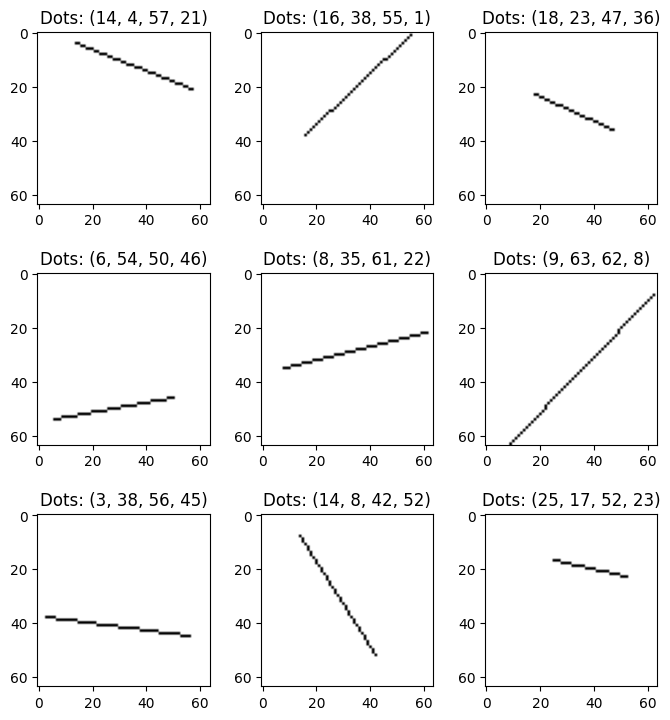

In [7]:
# Visualize 9 random lines
# torch.manual_seed(79)
fig = plt.figure(figsize=(8, 8))
plt.subplots_adjust(top = 0.9, bottom=0.01, hspace=0.05, wspace=0.3)
rows, cols = 3, 3
for i in range(1, rows*cols + 1):
  random_idx = torch.randint(0, SET_SIZE, size=[1]).item()
  img = Image.open('linedata/' + str(random_idx) + '.png')
  label = dots[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img, cmap='gray')
  plt.title(f"Dots: {label}")

Now that we got the data in the CSV, let us load the corresponding images and labels for building data loaders

### Preparing the Data

In [8]:
# convert generated coordinates to Tensors
dots = torch.Tensor(dots)

# Let's normalize them by dividing it by 63 (IMG_SIZE - 1)
dots = dots/63

# Check first 5
dots[:5]

tensor([[0.2540, 0.0000, 0.5079, 0.7778],
        [0.3175, 0.3492, 0.6190, 0.4444],
        [0.1905, 0.2540, 0.5238, 0.4762],
        [0.2381, 0.0794, 0.9048, 0.0952],
        [0.1905, 0.7778, 0.6190, 0.7778]])

In [9]:
# Lists that will contain the whole dataset
coordinates = []
img_list = []

convert_tensor = transforms.ToTensor()
with open('dataset.csv') as csvfile:
  rows = csv.reader(csvfile)
  columns = next(iter(rows))
  for row in rows:
    #Scaling Coordinates to the range of [0,1] by dividing the coordinate with image size
    arr = [float(row[3])/63.,
          float(row[4])/63.,
          float(row[5])/63.,
          float(row[6])/63.]
    coordinates.append(arr)
    img_path = row[0]

    # Read the image
    img = Image.open(os.path.join(IMAGE_DIR, img_path))
    img_tensor = convert_tensor(img)
    img_list.append(img_tensor.unsqueeze(dim=0))

In [10]:
coordinates = torch.Tensor(coordinates)
coordinates[:5]

tensor([[0.2540, 0.0000, 0.5079, 0.7778],
        [0.3175, 0.3492, 0.6190, 0.4444],
        [0.1905, 0.2540, 0.5238, 0.4762],
        [0.2381, 0.0794, 0.9048, 0.0952],
        [0.1905, 0.7778, 0.6190, 0.7778]])

In [11]:
b = torch.Tensor(SET_SIZE, 1, IMG_SIZE, IMG_SIZE)
b.shape
img_tensor = torch.cat(img_list, out=b)

In [12]:
coordinates.shape, img_tensor.shape

(torch.Size([10000, 4]), torch.Size([10000, 1, 64, 64]))

## Dataset Splitting

In [13]:
# Split the data of images, labels and their annotations
train_images, test_images, \
train_coordinates, test_coordinates = train_test_split( img_tensor,
                coordinates, test_size = 0.2,
                random_state = 43)

print('Training Images Count: {}, Test Images Count: {}'.format(
    len(train_images), len(test_images) ))

Training Images Count: 8000, Test Images Count: 2000


## Custom DataLoader

In [14]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

In [15]:
# Implementing device agnosctic code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [16]:
class Dataset():
  def __init__(self, train_images, train_coordinates):
    self.images = train_images
    self.coordinates = train_coordinates

  def __len__(self):
    return len(self.coordinates)

  # To return x,y values in each iteration over dataloader as batches.

  def __getitem__(self, idx):
    return (self.images[idx],
            self.coordinates[idx])

# Inheriting from Dataset class

class TestDataset(Dataset):
  def __init__(self, test_images, test_coordinates):
    self.images = test_images
    self.coordinates = test_coordinates

In [17]:
train_dataset = Dataset(train_images, train_coordinates)
test_dataset = TestDataset(test_images, test_coordinates)

## Model Architecture

So to understand how we have to design the architecture, we have to first understand input and outputs. Here the input is a batch of images, so it will be stylized like  (BS, C, H, W). BS being Batch Size and then Channels, Height, and Weight. The order is important, as in *PyTorch* that's how images are stored. In *TensorFlow*, it is (H, W, C) for each image.

In [18]:
# Turn datasets into iterables (batches)
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                         batch_size=BATCH_SIZE,
                                         shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=BATCH_SIZE,
                                             shuffle=False)

print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f3ff6bd3d30>, <torch.utils.data.dataloader.DataLoader object at 0x7f3ff85c9450>)
Length of train_dataloader: 250 batches of 32
Length of test_dataloader: 63 batches of 32


In [19]:
# checking the shapes of batches
train_features_batch, train_coordinates_batch = next(iter(train_dataloader))
train_features_batch.shape, train_coordinates_batch.shape

(torch.Size([32, 1, 64, 64]), torch.Size([32, 4]))

## CNN Model

In [20]:
class LineDetectionNet(nn.Module):
  def __init__(self):
    super(LineDetectionNet, self).__init__()
    self.conv = nn.Sequential(
      nn.Conv2d(in_channels=1,
                out_channels=3,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2,
                    stride=2)
    )
    self.fc = nn.Sequential(
      nn.Linear(in_features=3072,
                out_features=128),
      nn.ReLU(),
      nn.Linear(in_features=128,
                out_features=4)  # 4 output coordinates: x1, y1, x2, y2
    )

  def forward(self, x):
    x = self.conv(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    return x


In [21]:
# Let's see the model summary for better understanding of its architecture
m = LineDetectionNet()
summary(m, input_size=[1,1,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
LineDetectionNet                         [1, 4]                    --
├─Sequential: 1-1                        [1, 3, 32, 32]            --
│    └─Conv2d: 2-1                       [1, 3, 64, 64]            30
│    └─ReLU: 2-2                         [1, 3, 64, 64]            --
│    └─MaxPool2d: 2-3                    [1, 3, 32, 32]            --
├─Sequential: 1-2                        [1, 4]                    --
│    └─Linear: 2-4                       [1, 128]                  393,344
│    └─ReLU: 2-5                         [1, 128]                  --
│    └─Linear: 2-6                       [1, 4]                    516
Total params: 393,890
Trainable params: 393,890
Non-trainable params: 0
Total mult-adds (M): 0.52
Input size (MB): 0.02
Forward/backward pass size (MB): 0.10
Params size (MB): 1.58
Estimated Total Size (MB): 1.69

### Stepping through nn.Conv2d()

### train_step, test_step and timer functions

In [22]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Prints difference between start and end timme."""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [23]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
  """Performs a training with model trying to learn on data_loader."""
  train_loss = 0
  model.train()
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate loss(per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate train loss

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

  # Divide total loss by length of train dataloader
  train_loss /= len(data_loader)

  print(f"Train loss: {train_loss:.5f}")
  return train_loss

In [24]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = device):
  """Performs a testing loop step on model going over data_loader"""
  test_loss = 0

  # Put the model in eval mode
  model.eval()

  # Turn on inference mode context manager
  with torch.inference_mode():
    for X, y in data_loader:
      # Send the data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred = model(X)

      # 2. Calculate the loss
      test_loss += loss_fn(test_pred, y)

  # Adjust metrics and print out
    test_loss /= len(data_loader)
    print(f"Test loss: {test_loss:.5f}\n")
  return test_loss

In [25]:
torch.manual_seed(42)
timer_start = timer()

# Set epochs
epochs = 130

model= LineDetectionNet().to(device)
loss_fn= nn.MSELoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                               lr=0.005, momentum=0.9)



# Create empty results dictionary
results = {'train_loss': [],
            'test_loss': []}

# Create an optimization and evaluation loop using train_step() and test_step() functions

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------")

  train_result = train_step(model=model,
                            data_loader=train_dataloader,
                            loss_fn=loss_fn,
                            optimizer=optimizer,
                            device=device)
  test_result = test_step(model=model,
                          data_loader=test_dataloader,
                          loss_fn=loss_fn,
                          device=device)

  results['train_loss'].append(train_result.to('cpu').item())
  results['test_loss'].append(test_result.to('cpu'))

# Calculate training time
timer_end = timer()
total_train_time_model = print_train_time(start = timer_start,
                                          end = timer_end,
                                          device = str(next(model.parameters()).device))

  0%|          | 0/130 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.05931
Test loss: 0.05338

Epoch: 1
---------
Train loss: 0.05351
Test loss: 0.05185

Epoch: 2
---------
Train loss: 0.05116
Test loss: 0.04856

Epoch: 3
---------
Train loss: 0.04487
Test loss: 0.03994

Epoch: 4
---------
Train loss: 0.03275
Test loss: 0.02779

Epoch: 5
---------
Train loss: 0.02307
Test loss: 0.02086

Epoch: 6
---------
Train loss: 0.01837
Test loss: 0.01693

Epoch: 7
---------
Train loss: 0.01550
Test loss: 0.01453

Epoch: 8
---------
Train loss: 0.01343
Test loss: 0.01294

Epoch: 9
---------
Train loss: 0.01180
Test loss: 0.01154

Epoch: 10
---------
Train loss: 0.01039
Test loss: 0.01029

Epoch: 11
---------
Train loss: 0.00928
Test loss: 0.00931

Epoch: 12
---------
Train loss: 0.00831
Test loss: 0.00837

Epoch: 13
---------
Train loss: 0.00746
Test loss: 0.00754

Epoch: 14
---------
Train loss: 0.00667
Test loss: 0.00684

Epoch: 15
---------
Train loss: 0.00596
Test loss: 0.00621

Epoch: 16
---------
Train loss: 0.00534
Test loss:

In [26]:
def plot_loss_curves(results: dict[str, list[float]]):
  # Get the loss values of the results dictionary (training and test)
  loss = results['train_loss']
  print(results['train_loss'])
  test_loss = results['test_loss']

  # Figure out how many epochs there were
  epochs = range(len(results['train_loss']))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.plot(epochs, loss, label='train_loss')
  plt.plot(epochs, test_loss, label='test_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

[0.05930931866168976, 0.05351300165057182, 0.051162682473659515, 0.0448700375854969, 0.03275350481271744, 0.023069923743605614, 0.018373066559433937, 0.015499508939683437, 0.013434592634439468, 0.011799744330346584, 0.010393991135060787, 0.009277626872062683, 0.00831453874707222, 0.007464553229510784, 0.006669811438769102, 0.005964398384094238, 0.005342335905879736, 0.004790010396391153, 0.004288975149393082, 0.0038842963986098766, 0.0035393524449318647, 0.0032495532650500536, 0.0030150054953992367, 0.0027977260760962963, 0.002619875827804208, 0.0024607006926089525, 0.002317763864994049, 0.0021993457339704037, 0.002070865361019969, 0.00197030627168715, 0.0018883888842538, 0.0017991716740652919, 0.001727200928144157, 0.0016470379196107388, 0.0015821980778127909, 0.0015222192741930485, 0.0014674515696242452, 0.0014118917752057314, 0.001368968398310244, 0.0013326308690011501, 0.0012812070781365037, 0.0012408432085067034, 0.0012041795998811722, 0.0011777003528550267, 0.0011429545702412724,

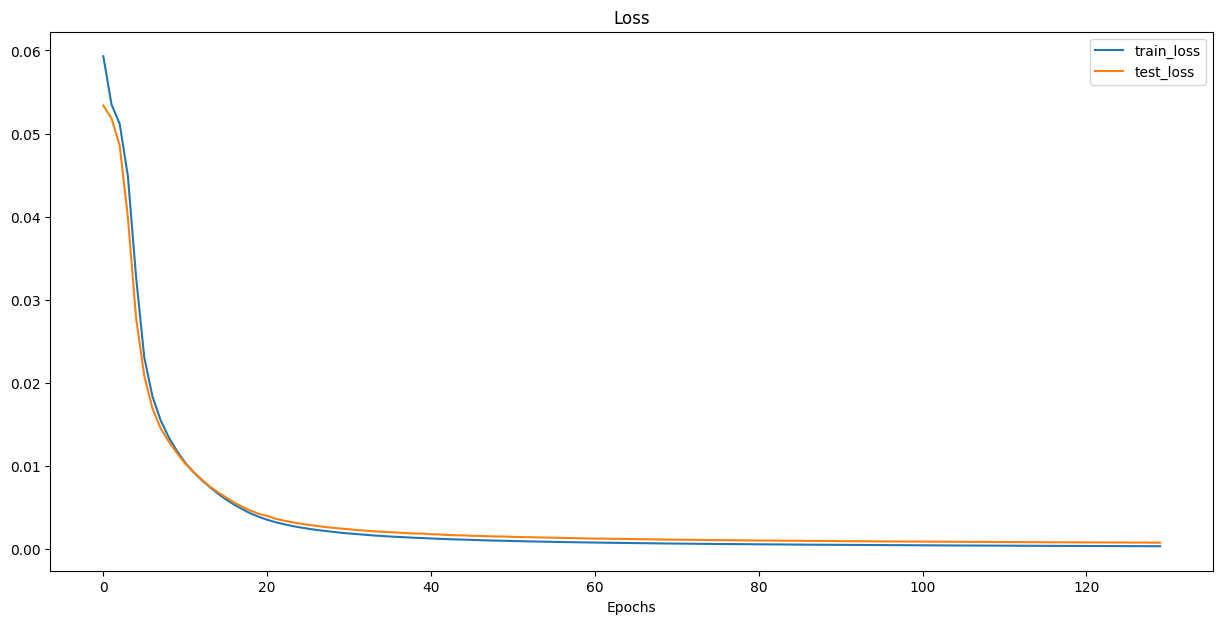

In [27]:
plot_loss_curves(results)

### Let's detect and visualize the coordinates with the help of the model

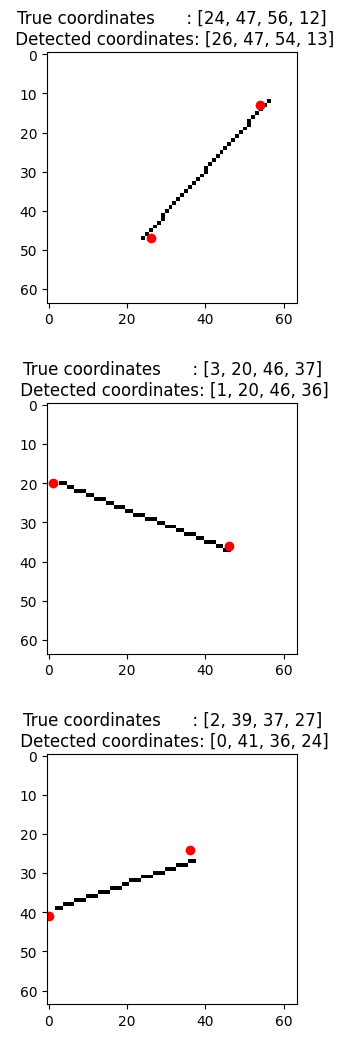

In [31]:
plt_size = 3
fig = plt.figure(figsize=(8, 8))
plt.subplots_adjust(top = 1.2, bottom=0.01, hspace=0.4, wspace=0.3)

# Choosing random images from test_dataset
idx = np.random.randint(0, len(test_dataset)-1, size = plt_size)
with torch.inference_mode():

  for pl, id in enumerate(idx):
    # plot 1 image per each row
    plt.subplot(3, 1, pl+1)
    plt.imshow(test_dataset.images[id].permute(1,2,0), cmap='gray')
    true_coordinates = (test_dataset.coordinates[id] * 63).tolist()
    true_coordinates = [int(x) for x in true_coordinates]

    model.eval()
    detected_coordinates = model(test_dataset.images[id].unsqueeze(dim=0).to(device)).squeeze()
    detected_coordinates *= 63
    detected_coordinates = [int(x) for x in detected_coordinates]

    plt.title(f'True coordinates      : {true_coordinates}\n Detected coordinates: {detected_coordinates}')
    # Plotting detected line coordinates by the NN algorithm
    plt.plot(detected_coordinates[0], detected_coordinates[1], 'ro')
    plt.plot(detected_coordinates[2], detected_coordinates[3], 'ro')

Thank you!
